<br><br>
# Case 2: Diabetic retinopathy

### Juha Nuutinen

### 13.02.2019

### Helsinki Metropolia University of Applied Sciences
<br><br>

# 1. Objectives
This notebook documents the process of using a convolutional neural network to detect the presence of diabetic retinopathy from images of the back of the eye (fundus photography). The goal for this assignment is to learn to use convolutional neural networks to classify medical images.

# 2. Required Libraries

In [1]:
# Required libraries
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import models

%matplotlib inline

from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


# 3. Data

### Origin

In 2015, California Health Foundation together with eyePacs announced the open [Kaggle competition for detecting diabetic retinopathy](https://www.kaggle.com/c/diabetic-retinopathy-detection). The competition opened a very large dataset of [fundus photography](https://en.wikipedia.org/wiki/Fundus_photography), provided by eyePacs. For this assignment, a [curated and smaller dataset](https://github.com/Nomikxyz/retinopathy-dataset) derived from the original is used.

### Description

The dataset contains a total of 2062 color JPEG images, and is about 2.1 GB in size. The images are rather large, with height and width varying between 2000-5000 pixels. They are divided into two directories: <i>symptoms</i> and <i>nosymptoms</i>.

### Preprocessing

#### Data splitting
keras' `ImageDataGenerator` will be used to handle the feeding of image batches for training the model. Loading all the training images to memory would be a waste of resources. The first step is to create a directory structure as follows:

```
case_2/
    nuutinen_case_2_retinopathy.ipynb
    Week 4. Create directories.ipynb
    retinopathy-dataset-master/
        nosymptoms/
        symptoms/
    dataset2/
        test/
            nosymptoms/
            symptoms/
        train/
            nosymptoms/
            symptoms/
        validation/
            nosymptoms/
            symptoms/
```
The notebook `Week 4. Create directories.ipynb` (by Sakari Lukkarinen & Juha Kopu, [Helsinki Metropolia University of Applied Sciences](http://metropolia.fi/en)) handles the creation of the above directory structure, splitting the data into training (50%), validation (25%) and test (25%) sets, and copying them to the corresponding directories. When the data is split into directories, using the image generators becomes very straight forward. The data splitting is done using scikit-learn's `train_test_split` function.

From now on, it is assumed that all the code in `Week 4. Create directories.ipynb` has been run, i.e. the above directory structure exists and the images have been copied to correspondig directories. The directory and file manipulation code is kept in a separate notebook for the sake of brevity.

#### Creating the image generators
The code cell below is a modified excerpt from Lukkarinen's and Kopu's notebook [here](https://github.com/sakluk/cognitive-systems-for-health-technology/blob/master/Week%204.%20Case%202%20-%20First%20trial.ipynb).

In [2]:
train_dir = "./dataset2/train"
validation_dir = "./dataset2/validation"

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Training set: ", end='')
train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    train_dir,
    # All images will be resized to 150x150
    target_size=(150, 150),

    # We read images in batches
    batch_size=64,
    
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary')

print("Validation set: ", end='')
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Training set: Found 1031 images belonging to 2 classes.
Validation set: Found 516 images belonging to 2 classes.


# 4. Modeling and compilation

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(80, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(80, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(80, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 80)      2240      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 80)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 80)        57680     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 80)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 80)        57680     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 80)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23120)             0         
__________

# 5. Training and and validation

In [4]:
# Our first trial is to read only 10 batches per epoch (10x16 = 160 images per epoch)
# and run only 5 epochs
history = model.fit_generator(
      train_generator,
      steps_per_epoch = 30,
      verbose = 1,
      epochs = 10,
      validation_data = validation_generator,
      validation_steps = 10)

# Save the model
model.save('case_2_run_1.h5')

Epoch 1/10
30/30 [==============================] - 169s 6s/step - loss: 0.6169 - acc: 0.7086 - val_loss: 0.5293 - val_acc: 0.7155
Epoch 2/10
30/30 [==============================] - 159s 5s/step - loss: 0.4913 - acc: 0.7554 - val_loss: 0.5047 - val_acc: 0.7293
Epoch 3/10
30/30 [==============================] - 158s 5s/step - loss: 0.4678 - acc: 0.7660 - val_loss: 0.5154 - val_acc: 0.7448
Epoch 4/10
30/30 [==============================] - 160s 5s/step - loss: 0.4356 - acc: 0.7909 - val_loss: 0.4795 - val_acc: 0.7707
Epoch 5/10
30/30 [==============================] - 164s 5s/step - loss: 0.4104 - acc: 0.7947 - val_loss: 0.4897 - val_acc: 0.7638
Epoch 6/10
30/30 [==============================] - 159s 5s/step - loss: 0.4119 - acc: 0.7862 - val_loss: 0.4959 - val_acc: 0.7707
Epoch 7/10
30/30 [==============================] - 159s 5s/step - loss: 0.3861 - acc: 0.8190 - val_loss: 0.4914 - val_acc: 0.7483
Epoch 8/10
30/30 [==============================] - 159s 5s/step - loss: 0.3759 - a

# 5. Results

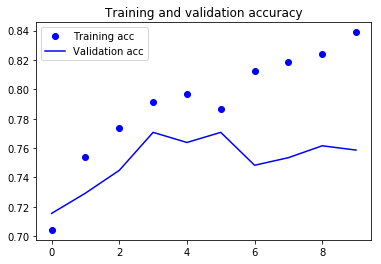

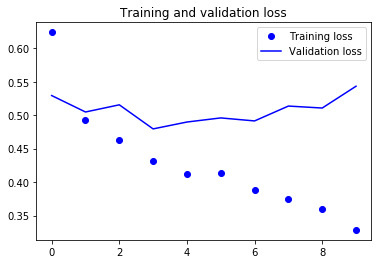

In [5]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()